In [ ]:
# !pip3 install kafka-python==1.4.7 streamz==0.5.2 --user

In [1]:
import os
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [2]:
import waterhealer as wh
from waterhealer import Stream
import json
import time
import confluent_kafka as ck

In [3]:
brokers = '10.148.15.246:7095,10.148.15.247:7095'

In [4]:
source = wh.from_kafka(
    ['testing'],
    {
        'bootstrap.servers': brokers,
        'group.id': 'group-test-4',
        'auto.offset.reset': 'earliest',
    })

In [5]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(loop = source.loop)
client = Client(cluster)

In [6]:
def json_loads(rows):
    results = []
    for row in rows:
        results.append(json.loads(row[1]))
        
    return results

def increment_left(rows):
    results = []
    for row in rows:
        row = row.copy()
        time.sleep(1)
        row['left'] = row['data'] + 1
        results.append(row)
    return results

def increment_right(rows):
    results = []
    for row in rows:
        row = row.copy()
        time.sleep(1)
        row['right'] = row['data'] + 1
        results.append(row)
    return results

def combine(tuples):
    
    left, right = tuples
    results = []
    for i in range(len(left)):
        time.sleep(1)
        results.append(left[i]['left'] + right[i]['right'])
        
    return results

In [7]:
partition = source.scatter().partition_time(5, checkpoint = True)
s = partition.map(json_loads, checkpoint = True)
s.buffer(8).gather().flatten().partition_time(5, checkpoint = True)

Output()

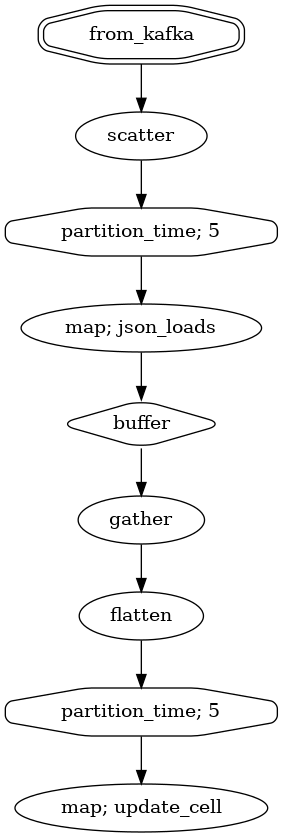

In [8]:
source.visualize()

In [9]:
source.start()

In [10]:
from kafka import KafkaProducer
from kafka.partitioner import RoundRobinPartitioner

In [11]:
producer = KafkaProducer(
    bootstrap_servers = brokers.split(','),
    api_version = (0, 10),
    partitioner = RoundRobinPartitioner(),
)

In [12]:
producer.bootstrap_connected()

True

In [13]:
from datetime import datetime
import json
from itertools import cycle

def publish_message(producer_instance, topic_name, key, value):
    try:
        key_bytes = bytes(key, encoding = 'utf-8')
        value_bytes = bytes(value, encoding = 'utf-8')
        x = producer_instance.send(topic_name, value = value_bytes)
        return True
    except Exception as ex:
        print('Exception in publishing message')
        print(str(ex))
        return False

In [14]:
import time

for i in range(10):
    data = {'i': i, 'data': i + 1}
    print(data)
    publish_message(
        producer, 'testing', 'streaming', json.dumps(data)
    )
    time.sleep(0.1)

{'i': 0, 'data': 1}
{'i': 1, 'data': 2}
{'i': 2, 'data': 3}
{'i': 3, 'data': 4}
{'i': 4, 'data': 5}
{'i': 5, 'data': 6}
{'i': 6, 'data': 7}
{'i': 7, 'data': 8}
{'i': 8, 'data': 9}
{'i': 9, 'data': 10}


In [17]:
%%time

source.wait()

CPU times: user 7.71 ms, sys: 3.34 ms, total: 11 ms
Wall time: 18 ms


True

In [18]:
source.checkpoint

{'from_kafka.scatter.partition_time': [({'partition': 0,
    'offset': 184,
    'topic': 'testing'},
   b'{"i": 0, "data": 1}'),
  ({'partition': 1, 'offset': 56, 'topic': 'testing'}, b'{"i": 1, "data": 2}'),
  ({'partition': 2, 'offset': 176, 'topic': 'testing'},
   b'{"i": 2, "data": 3}'),
  ({'partition': 3, 'offset': 54, 'topic': 'testing'}, b'{"i": 3, "data": 4}'),
  ({'partition': 4, 'offset': 175, 'topic': 'testing'},
   b'{"i": 4, "data": 5}'),
  ({'partition': 5, 'offset': 50, 'topic': 'testing'}, b'{"i": 5, "data": 6}'),
  ({'partition': 6, 'offset': 171, 'topic': 'testing'},
   b'{"i": 6, "data": 7}'),
  ({'partition': 7, 'offset': 49, 'topic': 'testing'}, b'{"i": 7, "data": 8}'),
  ({'partition': 8, 'offset': 171, 'topic': 'testing'},
   b'{"i": 8, "data": 9}'),
  ({'partition': 9, 'offset': 49, 'topic': 'testing'},
   b'{"i": 9, "data": 10}')],
 'from_kafka.scatter.partition_time.map.json_loads': [{'i': 0, 'data': 1},
  {'i': 1, 'data': 2},
  {'i': 2, 'data': 3},
  {'i': 3